<a href="https://www.kaggle.com/code/dkimdl/hw4-intro2dl-final?scriptVersionId=91473753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/birddata/birds_400/class_dict.csv
/kaggle/input/birddata/birds_400/submission.csv
/kaggle/input/birddata/birds_400/birds latin names.csv
/kaggle/input/birddata/birds_400/birds.csv
/kaggle/input/birddata/birds_400/valid/WATTLED CURASSOW/5.jpg
/kaggle/input/birddata/birds_400/valid/WATTLED CURASSOW/1.jpg
/kaggle/input/birddata/birds_400/valid/WATTLED CURASSOW/4.jpg
/kaggle/input/birddata/birds_400/valid/WATTLED CURASSOW/3.jpg
/kaggle/input/birddata/birds_400/valid/WATTLED CURASSOW/2.jpg
/kaggle/input/birddata/birds_400/valid/CARMINE BEE-EATER/5.jpg
/kaggle/input/birddata/birds_400/valid/CARMINE BEE-EATER/1.jpg
/kaggle/input/birddata/birds_400/valid/CARMINE BEE-EATER/4.jpg
/kaggle/input/birddata/birds_400/valid/CARMINE BEE-EATER/3.jpg
/kaggle/input/birddata/birds_400/valid/CARMINE BEE-EATER/2.jpg
/kaggle/input/birddata/birds_400/valid/GAMBELS QUAIL/5.jpg
/kaggle/input/birddata/birds_400/valid/GAMBELS QUAIL/1.jpg
/kaggle/input/birddata/birds_400/valid/GAMBELS QUAIL/4.jpg
/kag

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import os

In [3]:
# Hyper Parameters 
num_classes = 400
num_epochs = 5
batch_size = 16
learning_rate = 0.01

In [4]:
transform_dict = { 'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
                  'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
                 }
test_dict = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
root_path = '../input/birddata/birds_400/'
image_data = {x: dsets.ImageFolder(os.path.join(root_path,x),transform_dict[x]) for x in ['train','valid']}
data_loaders = {x: torch.utils.data.DataLoader(image_data[x], batch_size=batch_size, shuffle = True, drop_last= False, num_workers=2) for x in ['train','valid']}
dataset_sizes = {x: len(image_data[x]) for x in ['train','valid']}

test_root_path = '../input/birddata/birds_400/test'
test_data = dsets.ImageFolder(root=test_root_path, transform=test_dict)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = True, drop_last=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

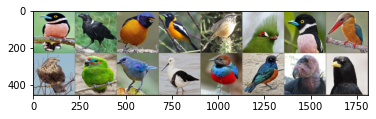

In [5]:
import numpy as np
import matplotlib as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.pyplot.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pyplot.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(test_data_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [6]:
import torchvision.models as models
resnet = models.resnet101(pretrained=True)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [7]:
import time
import copy

def train_model(model,criteron,optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        for phase in ['train','valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

        
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects/dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')


    model.load_state_dict(best_model_wts)
    return model        

In [8]:
resnet = models.resnet101(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
    
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, num_classes)
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
model_fit = train_model(resnet,criterion,optimizer,scheduler,num_epochs)

train Loss: 3.8191 Acc: 0.4202
valid Loss: 1.9209 Acc: 0.7565

train Loss: 1.7786 Acc: 0.7667
valid Loss: 1.0190 Acc: 0.8655

train Loss: 1.1874 Acc: 0.8303
valid Loss: 0.6901 Acc: 0.9050

train Loss: 0.9298 Acc: 0.8555
valid Loss: 0.5706 Acc: 0.9140

train Loss: 0.7920 Acc: 0.8700
valid Loss: 0.4647 Acc: 0.9295

Training complete in 17m 49s
Best val Acc: 0.929500


In [10]:
# Test the Model
import torch.nn.functional as F
running_corrects = 0
running_loss = 0
for inputs, labels in test_data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_fit(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    probs = F.softmax(outputs,1)
epoch_loss = running_loss/len(test_data)
epoch_acc = running_corrects/len(test_data)
    
print('Accuracy of the model on the 2000 test images: %d %%' % (100 * epoch_acc))

Accuracy of the model on the 2000 test images: 94 %


In [11]:
zero_test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=5, shuffle = False, drop_last=False, num_workers=2)
for zinputs, zlabels in zero_test_data_loader:
    zinputs = zinputs.to(device)
    zlabels = zlabels.to(device)
    zoutputs = model_fit(zinputs)
    _, zpreds = torch.max(zoutputs, 1)
    zloss = criterion(zoutputs, zlabels)
    zprobs = F.softmax(zoutputs,1)

In [12]:
#Confirming that for label 399, log loss is 0.9348
zloss

tensor(0.8139, device='cuda:0', grad_fn=<NllLossBackward>)

In [13]:
import itertools
log_loss = []
for i in range(1):
    sample = (i*5)+1
    k = int(np.floor(sample/5))
    for my_input,my_label in itertools.islice(zero_test_data_loader,k,None):
        my_input = my_input.to(device)
        my_label = my_label.to(device)
        my_outputs = model_fit(my_input)
        _,mypreds = torch.max(my_outputs,1)
        my_loss = criterion(my_outputs,my_label)
        log_loss.append(my_loss)
log_loss

[tensor(1.8005, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(1.6315, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.2282, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0317, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(1.1101, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.6983, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.4162, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.1561, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.2873, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.2173, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.5163, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.4907, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0695, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.1674, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0771, device='

In [14]:
log_loss = torch.FloatTensor(log_loss)

In [15]:
Id = np.arange(400)
my_submission = pd.DataFrame({'Id': Id, 'birds': log_loss})
my_submission.to_csv('Daniel_submission.csv',index=False)

In [16]:
import gc
gc.collect()
torch.cuda.empty_cache() 